<a href="https://colab.research.google.com/github/wizard339/education/blob/main/torch_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сегодня мы рассмотрим основные компоненты библиотеки Pytorch и посмотрим из чего ссостоит стандартный pipeline обучения любой модели, обученной с использованием библиотеки Pytorch


Основные компоненты системы выглядят следующим образом с кратким описанием того, что они делают и что позволяют сделать

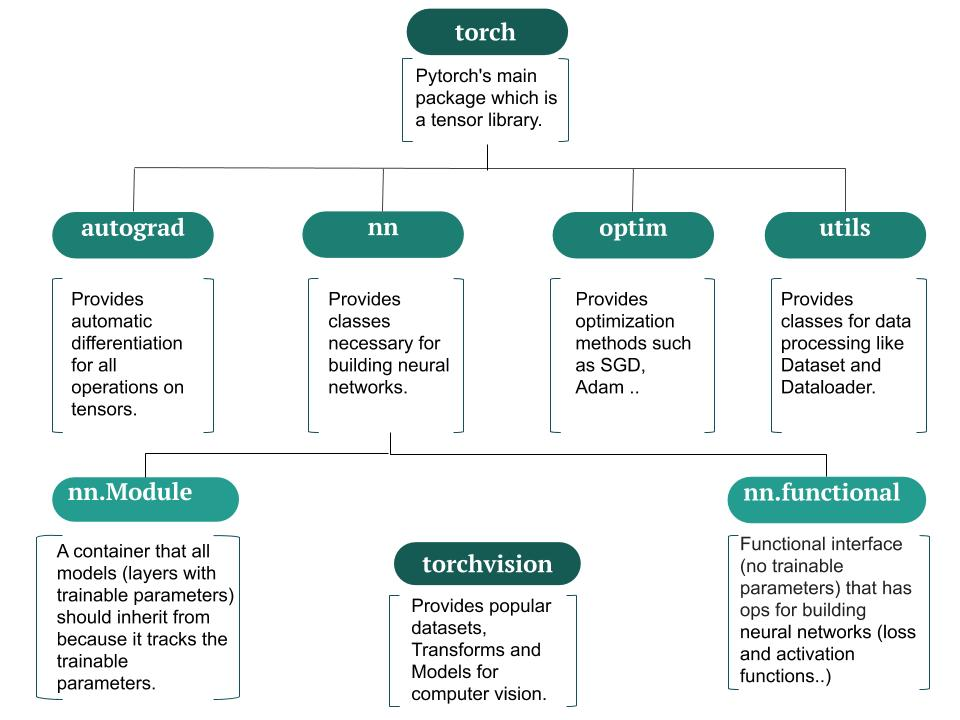

Общий pipeline тренировки и внедрения можно грубо описать следующей картинкой

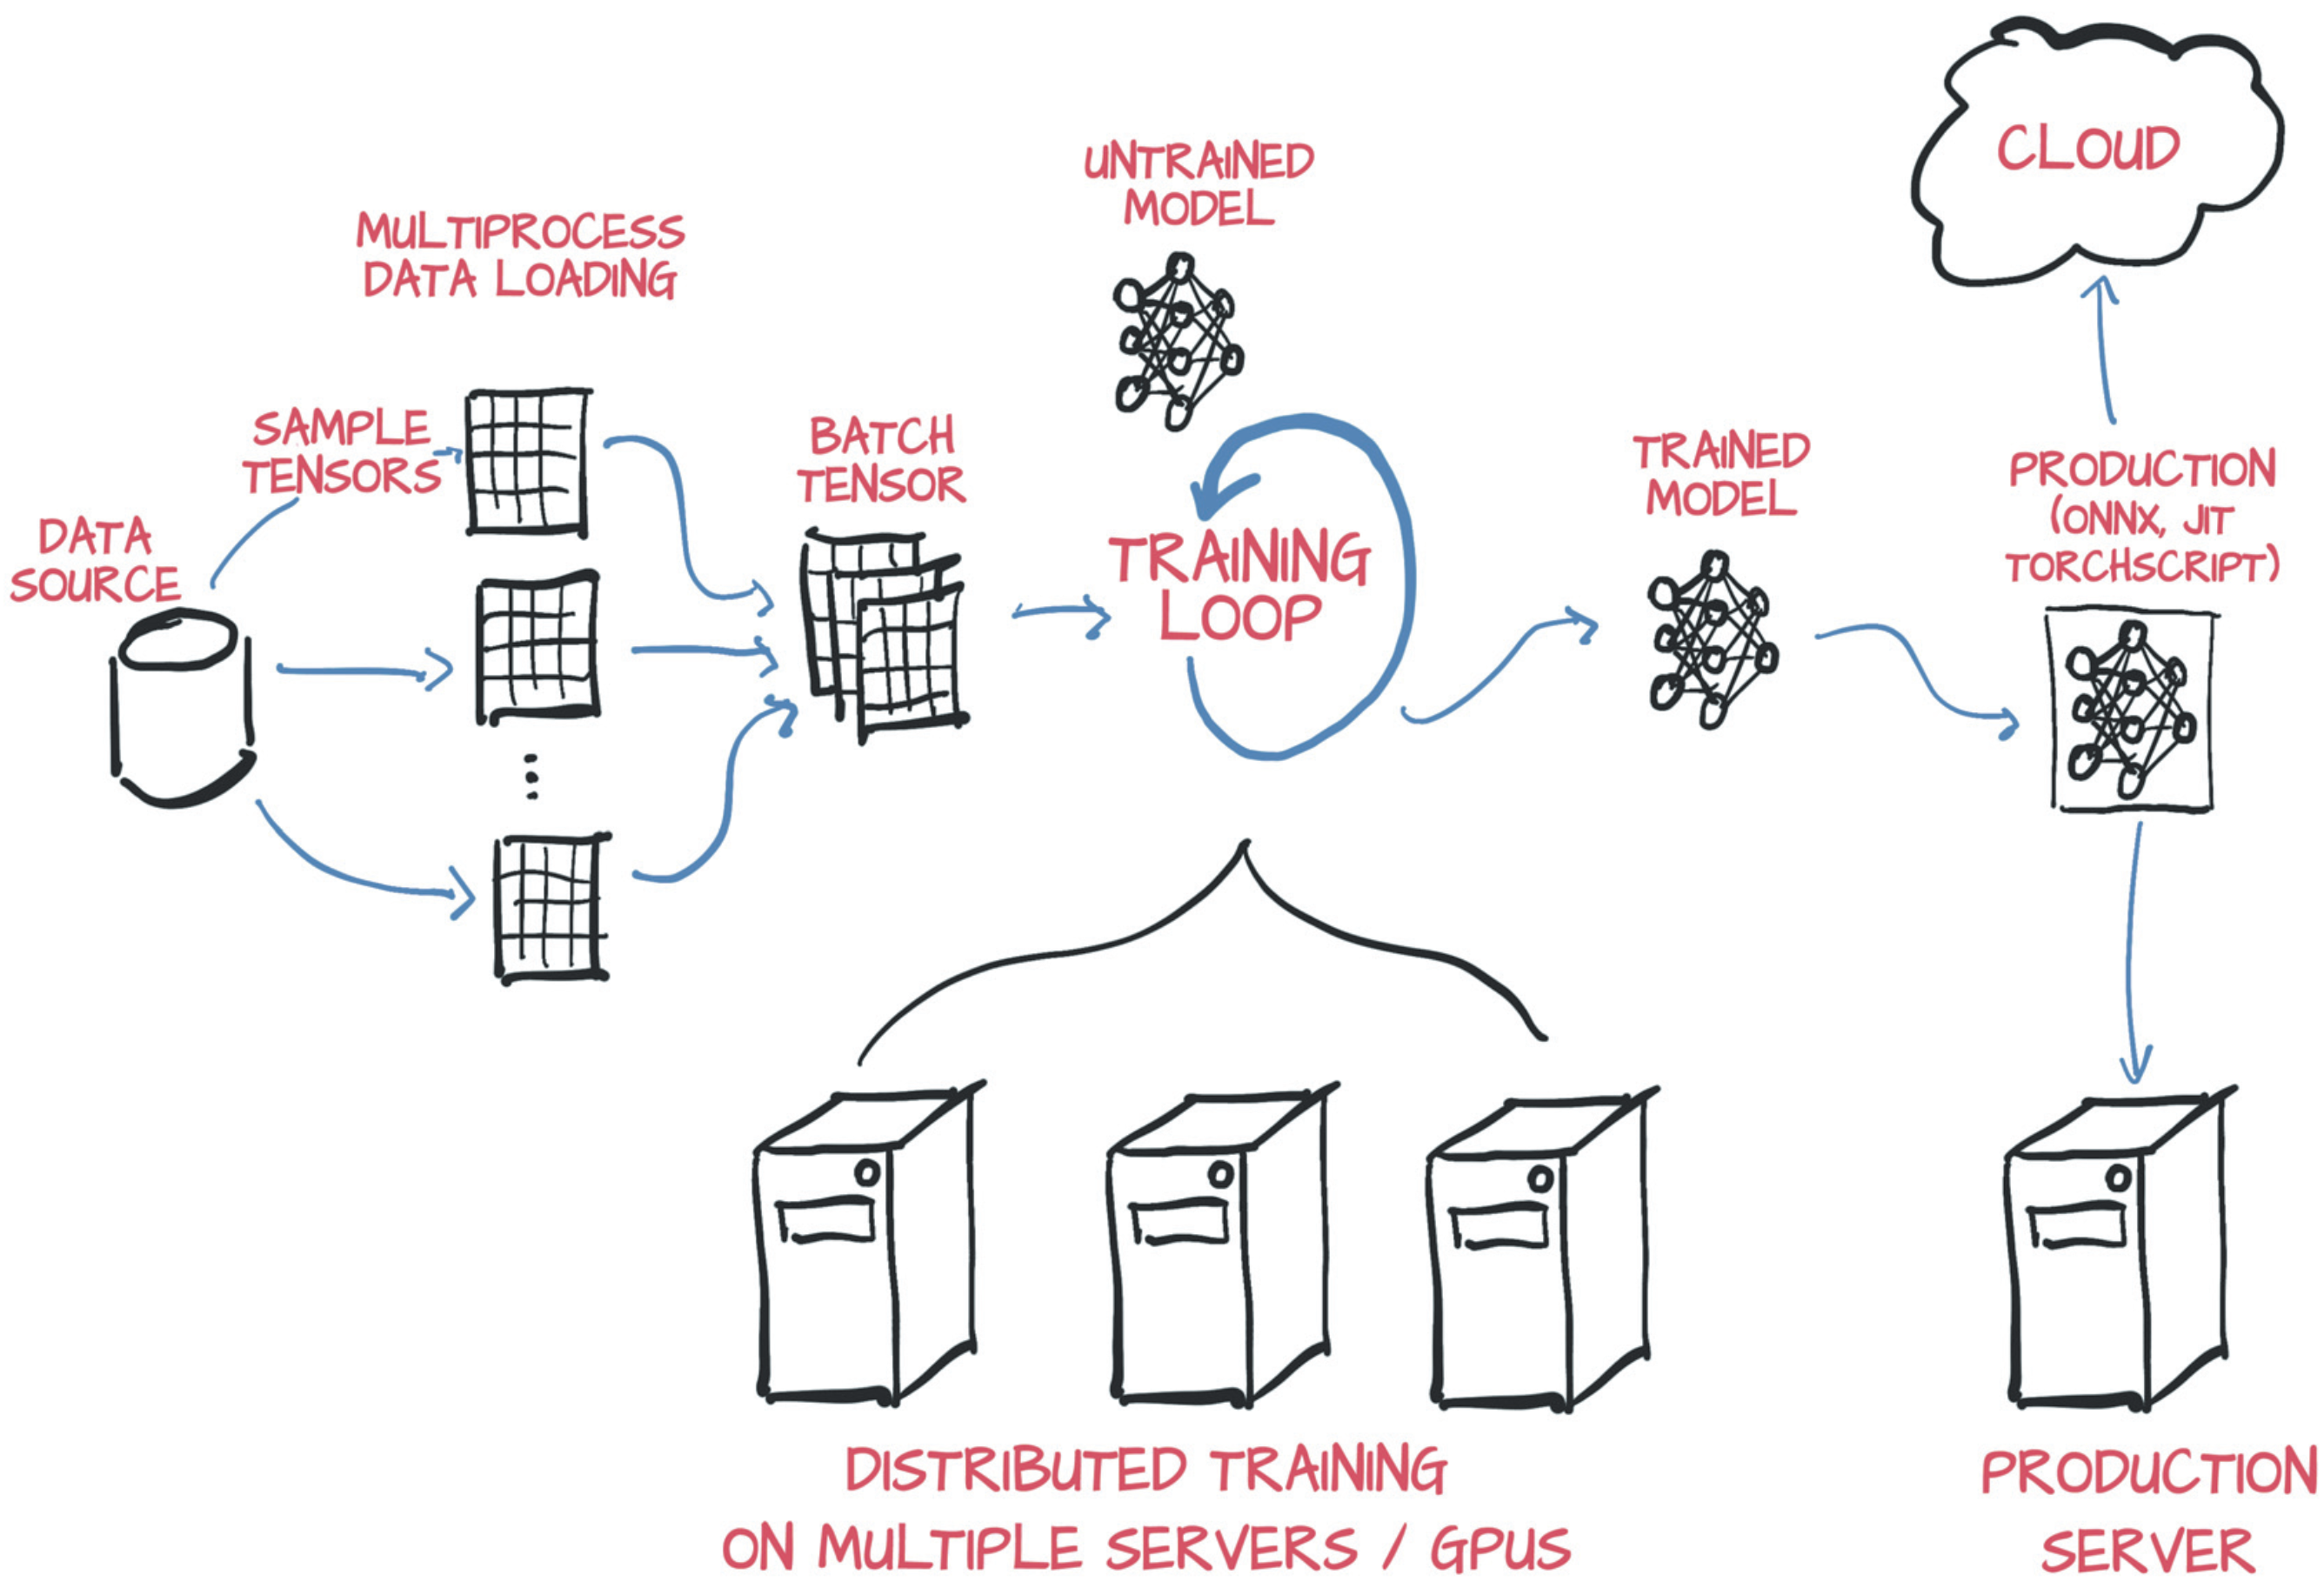

# Работа с данными

Упрощенно, работа с данными выглядит следующим образом

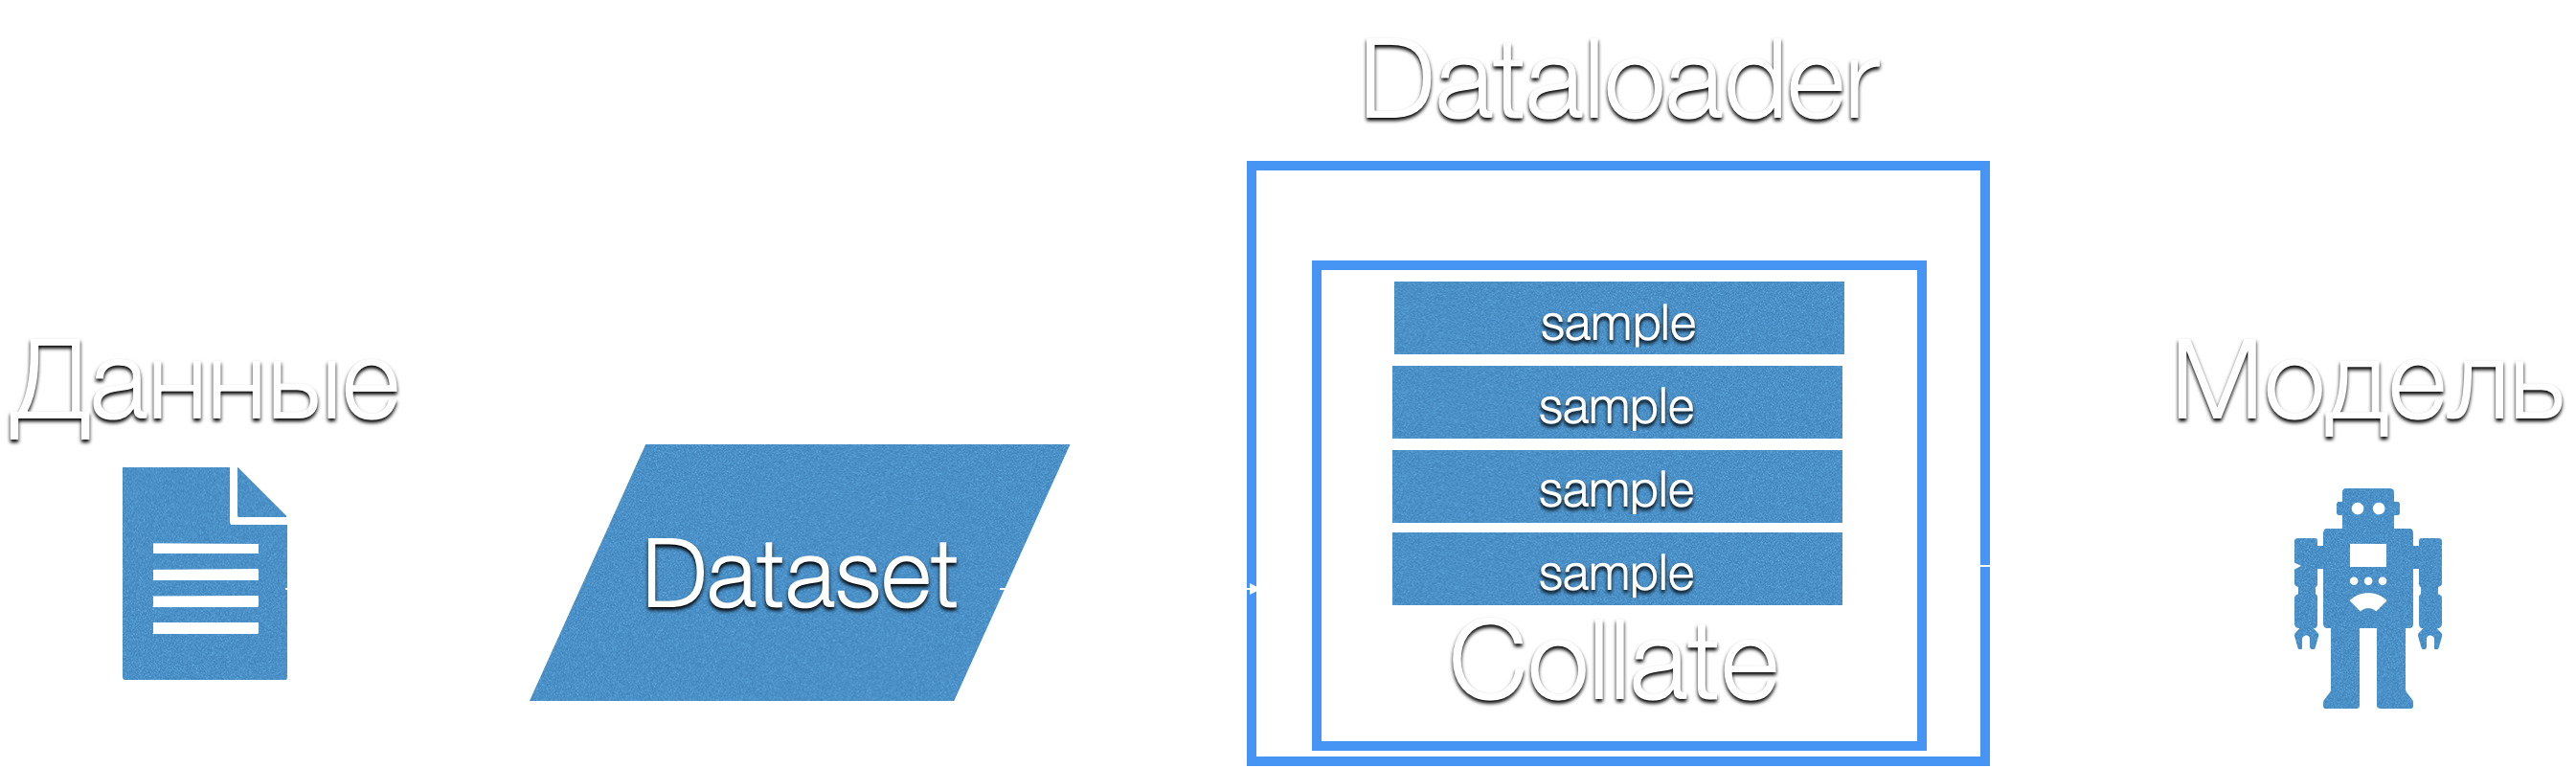

Давайте разберем каждую компоненту отдельно

## Данные

Первооснова любого решения, основанного на нейронных сетях или машинном обучении являются данные. Без них мы попросту не сможем ничего обучить и в дальнейшем решать задачу. <br>
Данные могут быть представлены в любом виде - `json`-файл,  `csv`-файл, файл с базой данных. Вариантов тут может быть колоссальное количество. Не будем останавливаться подробно, будем рассматривать на примере обычного текстового файла.

В качестве данных мы будем использовать датасет с отзывами пользователей о женской одежде

In [1]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('/content/Womens Clothing E-Commerce Reviews.csv',index_col =[0])
print(data.shape)
data.head(2)

(23486, 10)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses


В качестве таргета будем использовать колонку `Recomended IND`, а в качестве текстового поля - `Review Text`

In [4]:
data = data[~data['Review Text'].isna()]

In [5]:
data['Recommended IND'].value_counts(normalize=True)

1    0.818868
0    0.181132
Name: Recommended IND, dtype: float64

видим, что классы не сбалансированны

In [6]:
NUM_CLASSES = data['Recommended IND'].nunique()

In [7]:
texts = data['Review Text'].str.lower().values
targets = data['Recommended IND'].values

In [8]:
from sklearn.model_selection import train_test_split

texts_train, texts_test, y_train, y_test = train_test_split(texts, targets, random_state=2029, test_size=0.2)

In [9]:
from collections import Counter

Counter(y_train).most_common(), Counter(y_test).most_common()

([(1, 14868), (0, 3244)], [(1, 3672), (0, 857)])

Посмотрев на данные (здесь мы сделали это совсем бегло, по хорошему нужно отнестись к этому куда более ответственно) можем перейти к рассотрению следующей компоненты Pytorch

## Dataset

Чтобы работать с данными нам надо подавать наши данные в специальный класс `Dataset`. <br>
Pytorch поддерживает два различных типа Dataset'а. Они различаются между собой как будут выдаваться данные при обращении к этому классу. Различают `map` датасет и `__iter__` датасет. Основное отличие в том, что первый - позволяет позволяет хранить у себя весь датасет и обращение каждый раз идет к определенному индексу. По этому индексу забирается набор данных и выдается в удобном программисту виде. Второй тип датасета нужен в том случае, когда данные поддерживают последовательное чтение, и нет необходимости бегать по индексам датасета. Это может быть удобно, когда ваш набор данных слишком велик.

В нашей практике мы будем работать только с датасетом `map`

Для того чтобы определить свой класс для работы с данными достаточно определить в нашем классе два метода - `__len__` и `__getitem__`. Дававайте напишем наш класс.

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F

In [11]:
class CustomDataset:
  def __init__(self, data, targets, tokenize, word2index):
    self.data = data
    self.targets = targets
    self.tokenize = tokenize
    self.word2index = word2index

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    text = self.data[idx] # берем конкретную строчку по индексу
    label = self.targets[idx] # берем конкретную строчку по индексу
    row = self.tokenize(text) # преобразуем текст в токены переданной функцией токенизации
    ids = list()
    for ind, word in enumerate(row):
        ids.append(self.word2index.get(word, 0))  # считаем, что 0 индексу в словаре
                                                  #  соответствует неизвестное слово 
    
    return {
        'text': ids,
        'label': label
    }

Теперь нам нужно доопределить некоторые элементы для корректной работы, а именно токенизатор и словарь с индексами слов.

In [12]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()

In [13]:
word2index = dict()
word2index['<UNK>'] = 0
word2index['<PAD>'] = 1

for doc in texts_train:
  for word in tokenizer.tokenize(doc):
    if word not in word2index:
      word2index[word] = len(word2index)
len(word2index)

13248

In [ ]:
# word2index

In [14]:
dataset = CustomDataset(texts_train, y_train, tokenizer.tokenize, word2index)
dataset[0]

{'text': [2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  9,
  15,
  4,
  16,
  17,
  4,
  18,
  19,
  20,
  21,
  22,
  17,
  10,
  23,
  4,
  24,
  22,
  25,
  22,
  26,
  15,
  23,
  4],
 'label': 1}

Перейдем к следующей составляющей - Dataloader

## Dataloader

Именно эта компонента берет примеры по определенным индексам из класса Dataset, объединяет их в батч, а после уже этот батч будет обрабатываться моделью. <br>
За выбор примеров из класса Dataset отвечает специальный класс Sampler, так что если вы хотите определить свой специализированный класс/метод для сэмплирования - достаточно переопределить этот класс, унаследововашись от исходного класса `torch.utils.data.sampler.Sampler`.<br>

Еще один важный момент - объединение примеров в батч. Как вы могли заметить, в нашем примере каждый пример из класса может иметь разную длину, что неприемлимо для батча на вход сети. За объединение примеров в батч отвечает встроенная функция `collate_fn`. В стандартной реализации эта функция просто делает torch.stack всех примеров и возвращает батч данных. Нам такой вариант не подходит, поэтому мы будем сначала выравнивать все наши примеры, а уже потом объединять в батч и выдавать на выход. Напишем свою функцию `collate_fn`. <br>
P.S. Иногда удобно заменить ее написанием функции, с определенным методом `_call__`.

In [15]:
def collate_fn(batch): # функция для сборки батча в единую матрицу
  max_len = max(len(sample['text']) for sample in batch) # находим максимальную длину строки среди всех примеров в батче
  text_ids, target_ids = list(), list()
  for item in batch:
    ids_to_add = item['text'] 
    if len(ids_to_add) < max_len:
      ids_to_add += [1] * (max_len - len(ids_to_add)) # добавляем [1] - это символ паддинга
    text_ids.append(ids_to_add)
    target_ids.append(item['label'])
  return {
      'text': torch.tensor(text_ids, dtype=torch.long),
      'label': F.one_hot(torch.tensor(target_ids,
                                      dtype=torch.long),
                          num_classes=NUM_CLASSES)
      }

In [16]:
loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [17]:
iter(loader).__next__()['text']

tensor([[    6,   475,     9,    62,   107,   267,   186,   383,    33,   773,
             4,    62,   107,    74,   166,     2,     4,     6,  2438,    74,
            57,   651,   269,     4,    18,    55,  2186,   552, 11548,    78,
          1687,   265,   310,   108,    18,   223,    57,   649,     4,  2602,
          2532,    22,   595,    78,    62,   107,     4,     6,   909,    23,
            74,   180,  1806,   182,     4,    33,    74,   602,   138,    70,
             6,     8,   271,   192,   136,    72,    34,    18,    55,    28,
           218,   312,     4,    33,    19,   125,   190,   296,  3728,   751,
             4,    18,   230,    18,    19,    20,    70,     5,    78,   965,
           966,  5111,   575,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1],
        [  429,    23,    43,  1839,    76,   800,   635,   245,    57,   172,
           485,     4,   563,   275,   192,   136,    37,   218, 

Теперь, когда мы закончили работу с данными, можем перейти к инициализации модели и работе с ней

## Model

Для нашей немного игрушечной задачи мы будем использовать простую модель на основе рекуррентной сети `LSTM`.

Чтобы наша сеть корректно работала в Pytorch должно быть выполнено 2 условия:
- унаследовать класс от класса `nn.Module`
- определить метод `forward`, в котором будет считаться forwardpass нашей сети.

In [18]:
class RNN(nn.Module):
  def __init__(self, vocab_size, embedding_length, hidden_size, n_classes=NUM_CLASSES):
    super(RNN, self).__init__() # нужно для создания всех методов, унаследованных от класса nn.Module
    
    # дальше обычно идет блок переменных, которые передаются при создании экземпляра класса
    self.vocab_size = vocab_size
    self.embedding_length = embedding_length
    self.hidden_size = hidden_size
    self.n_classes = n_classes 
		
    # здесь будем создавать все слои нашей сети
    self.embedding = nn.Embedding(self.vocab_size, self.embedding_length)
    self.rnn = nn.LSTM(self.embedding_length, self.hidden_size)
		
    self.projection = nn.Linear(self.hidden_size, self.n_classes)
	
  def forward(self, x):
    emb = self.embedding(x)
    out, _ = self.rnn(emb)
    out = self.projection(out)
    return out

Проверим, корректно ли мы создали сеть и правильно ли считается loss для нашей модели. Лучше начинать с такой проверки, прежде чем писать весь цикл обучения/валидации модели.

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else  torch.device('cpu')

criterion = torch.nn.CrossEntropyLoss()

sample = iter(loader).__next__() # 

print('sample on start -> ', sample['text'].shape)
model = RNN(len(word2index), 256, 64).to(device)
print(model(sample['text'].to(device)).shape, sample['label'].shape)
criterion(model(sample['text'].to(device)).cpu(), sample['label'])

sample on start ->  torch.Size([4, 51])
torch.Size([4, 51, 2]) torch.Size([4, 2])


tensor(3.9267, grad_fn=<NllLoss2DBackward0>)

Убедившись что лосс считается, можем переходить к дальнейшим шагам при работе с моделью.

Так как у нас классы не сбалансированны, то нам нужно использовать метрику, которая будет учитывать дисбаланс классов. Возьмем `f-score` для этого.

In [20]:
from sklearn.metrics import f1_score

## Тренировка/Валидация модели

Теперь нам нужно определить функцию потерь и оптимизатор для нашей модели. Так как в оптимизатор мы будем передавать параметры нашей сети, то он должен быть определен только после инициализации модели

In [21]:
# hyperparameters
EPOCHS = 7
LR = 3e-4 
BATCH_SIZE = 32

model = RNN(len(word2index), 256, 64).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LR, weight_decay=1e-4) # for first iter Adam is one of the best optimizers

Теперь давайте напишем функции для обучения и валидации модели

В рамках урока мы не будем сильно упираться в разбиение кода. Нам важно понять общую конву.

In [47]:
def train(dataloader, optimizer=optimizer, criterion=criterion, device=device):
    model.train() # задаем, что наша сеть теперь находится в режиме обучения
    total_count, total_loss = 0, 0 # переменные для дальнейшего обучения
    true_scores, pred_scores = list(), list()
    start_time = time.time()

    for idx, batch in enumerate(tqdm(dataloader)): # пробегаемся по всем примерам в даталоадере, беря данные батчами
        text = batch['text'].to(device)
        label = batch['label'].to(device)
        optimizer.zero_grad() # сбрасываем значения всех градиентов в ноль, чтобы не получить фантомных значений при backprop
        predited_label = model(text) #делаем предсказание 
        loss = criterion(predited_label, label) # считаем loss
        loss.backward() # запускаем вычисление backpropogation
        total_loss += loss
        optimizer.step() # делаем шаг оптимизатора (обновляем веса модели)
        scores = np.argmax(predited_label.detach().cpu().numpy(), axis=1)  # получаем OHE предсказания
        label = label.to('cpu').numpy()
        
        true_scores.extend(np.argmax(label, axis=1)) # записываем все лейблы в переменные для подсчета метрик качества модели
        pred_scores.extend(np.argmax(scores, axis=1))

        total_count += len(label)
    elapsed = time.time() - start_time
    print('| epoch {:3d} | {:5d}/{:5d} batches '
          '| f-score {:8.3f}| loss {:8.3f}'.format(epoch, idx, len(dataloader),
                                                   f1_score(true_scores, pred_scores, average='weighted'),
                                                   total_loss/total_count
                                                   )
          )
    total_acc, total_count = 0, 0
    start_time = time.time()

In [49]:
def evaluate(dataloader):
    model.eval() # переводим модель в режим inference (только делаем предсказания)
    total_count, total_loss = 0, 0
    true_scores, pred_scores = list(), list()

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            text = batch['text'].to(device)
            label = batch['label'].to(device)
            predited_label = model(text)
            total_loss += criterion(predited_label, label)
            scores = np.argmax(predited_label.detach().cpu().numpy(), axis=1)
            label = label.to('cpu').numpy()

            true_scores.extend(np.argmax(label, axis=1))
            pred_scores.extend(np.argmax(scores, axis=1))

            total_count += len(label)
    print('| epoch {:3d} | {:5d}/{:5d} batches '
    '| f-score {:8.3f}| loss {:8.3f}'.format(epoch, idx,
                                              len(dataloader),
                                              f1_score(true_scores, pred_scores, average='weighted'),
                                              total_loss/total_count)
    )
    return f1_score(true_scores, pred_scores, average='weighted')

In [43]:
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]
f1_score(y_true, y_pred, average='macro')

0.26666666666666666

In [50]:
from torch.utils.data.dataset import random_split
import time
from tqdm import tqdm


total_accu = None

num_train = int(len(dataset) * 0.8)
split_train_, split_valid_ = \
    random_split(dataset, [num_train, len(dataset) - num_train])

train_dataloader = torch.utils.data.DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_fn) # инициализируем наши даталоадеры
valid_dataloader = torch.utils.data.DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_fn)


for epoch in range(1, EPOCHS + 1): # считаем EPOCHS эпох
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid f-score {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

100%|██████████| 453/453 [00:02<00:00, 206.46it/s]


| epoch   1 |   452/  453 batches | f-score    0.742| loss    0.021
| epoch   1 |   113/  114 batches | f-score    0.746| loss    0.022
-----------------------------------------------------------
| end of epoch   1 | time:  2.44s | valid f-score    0.746 
-----------------------------------------------------------


100%|██████████| 453/453 [00:02<00:00, 214.31it/s]


| epoch   2 |   452/  453 batches | f-score    0.740| loss    0.021
| epoch   2 |   113/  114 batches | f-score    0.751| loss    0.021
-----------------------------------------------------------
| end of epoch   2 | time:  2.36s | valid f-score    0.751 
-----------------------------------------------------------


100%|██████████| 453/453 [00:02<00:00, 216.62it/s]


| epoch   3 |   452/  453 batches | f-score    0.742| loss    0.021
| epoch   3 |   113/  114 batches | f-score    0.757| loss    0.021
-----------------------------------------------------------
| end of epoch   3 | time:  2.33s | valid f-score    0.757 
-----------------------------------------------------------


100%|██████████| 453/453 [00:02<00:00, 217.25it/s]


| epoch   4 |   452/  453 batches | f-score    0.745| loss    0.021
| epoch   4 |   113/  114 batches | f-score    0.752| loss    0.021
-----------------------------------------------------------
| end of epoch   4 | time:  2.34s | valid f-score    0.752 
-----------------------------------------------------------


100%|██████████| 453/453 [00:02<00:00, 219.22it/s]


| epoch   5 |   452/  453 batches | f-score    0.746| loss    0.021
| epoch   5 |   113/  114 batches | f-score    0.752| loss    0.021
-----------------------------------------------------------
| end of epoch   5 | time:  2.32s | valid f-score    0.752 
-----------------------------------------------------------


100%|██████████| 453/453 [00:02<00:00, 216.92it/s]


| epoch   6 |   452/  453 batches | f-score    0.746| loss    0.021
| epoch   6 |   113/  114 batches | f-score    0.749| loss    0.021
-----------------------------------------------------------
| end of epoch   6 | time:  2.33s | valid f-score    0.749 
-----------------------------------------------------------


100%|██████████| 453/453 [00:02<00:00, 216.03it/s]


| epoch   7 |   452/  453 batches | f-score    0.748| loss    0.021
| epoch   7 |   113/  114 batches | f-score    0.756| loss    0.021
-----------------------------------------------------------
| end of epoch   7 | time:  2.35s | valid f-score    0.756 
-----------------------------------------------------------


## Выводы и дальнейшие шаги

Вы можете проделать следующие шаги для улучшения модели и отработки навыков:
- добавить аугментацию данных
- сделать модель чуть сложнее (например добавить num_layers в LSTM или сделать ее bidirectional)
- вынести часть кода из функций train и validate в отдельные функции train_epoch и validate_epoch
- добавить отрисовку значений loss для train и validation

Пример аугментации - замена случайного слова на токен `<UNK>`<br>
тогда класс Dataset чуть преобразуется:

In [ ]:
class CustomDataset:
  def __init__(self, data, targets, tokenize, word2index, transform=None):
    self.data = data
    self.targets = targets
    self.tokenize = tokenize
    self.transform = transform # добавили тут
    self.word2index = word2index

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    text = self.data[idx] # берем конкретную строчку по индексу
    label = self.targets[idx] # берем конкретную строчку по индексу
    row = self.tokenize(text) # преобразуем текст в токены переданной функцией токенизации
    if self.transform is not None: # добавили тут
      row = self.transform(row)
    ids = list()
    for ind, word in enumerate(row):
        ids.append(self.word2index.get(word, 0))  # считаем, что 0 индексу в словаре
                                                  #  соответствует неизвестное слово 
    
    return {
        'text': ids,
        'label': label
    }

In [ ]:
from typing import List
import random

class RandomUnknownTransform:
  def __init__(self, p=0.5, unk_token='<UNK>'):
    self.unk_token = unk_token
    self.p = p
  
  def apply(self, data: List[str]):
    pass   # Fill your code here
    
    # 1. select random token from doc
    # 2. if random probability greater than self.p
    # change selected word on self.unk_token
    # return transformed doc